In [42]:
pip install google


   ---------------------------------------- 0.0/45.3 kB ? eta -:--:--
   --------------------------- ------------ 30.7/45.3 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 45.3/45.3 kB 745.1 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\Brian\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Loaded 1000 records from C:\Users\Brian\.cache\kagglehub\datasets\harshitshankhdhar\imdb-dataset-of-top-1000-movies-and-tv-shows\versions\1\imdb_top_1000.csv
Initial Data Summary:
{
    "Row count": 1000,
    "Column count": 16,
    "Missing values": {
        "Poster_Link": 0,
        "Series_Title": 0,
        "Released_Year": 0,
        "Certificate": 101,
        "Runtime": 0,
        "Genre": 0,
        "IMDB_Rating": 0,
        "Overview": 0,
        "Meta_score": 157,
        "Director": 0,
        "Star1": 0,
        "Star2": 0,
        "Star3": 0,
        "Star4": 0,
        "No_of_Votes": 0,
        "Gross": 169
    },
    "Data types": {
        "Poster_Link": "object",
        "Series_Title": "object",
        "Released_Year": "object",
        "Certificate": "object",
        "Runtime": "object",
        "Genre": "object",
        "IMDB_Rating": "float64",
        "Overview": "object",
        "Meta_score": "float64",
        "Director": "object",
        "Star1": "object"

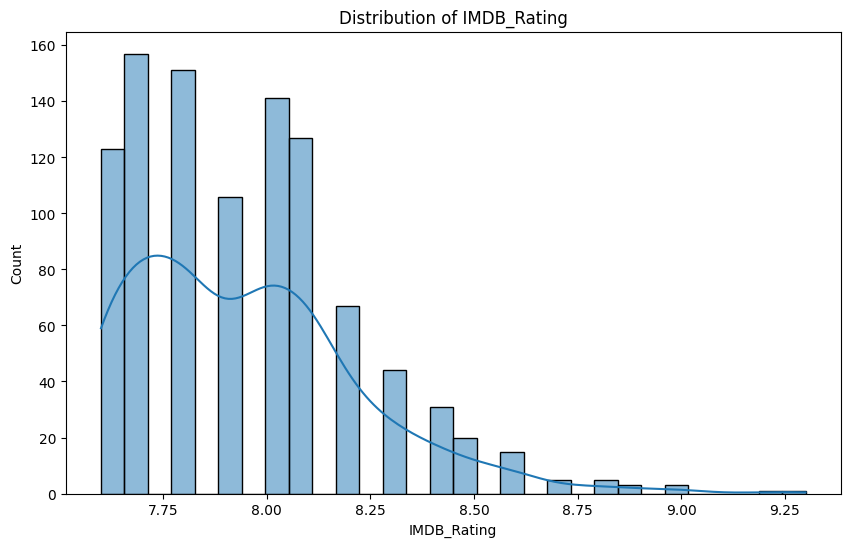

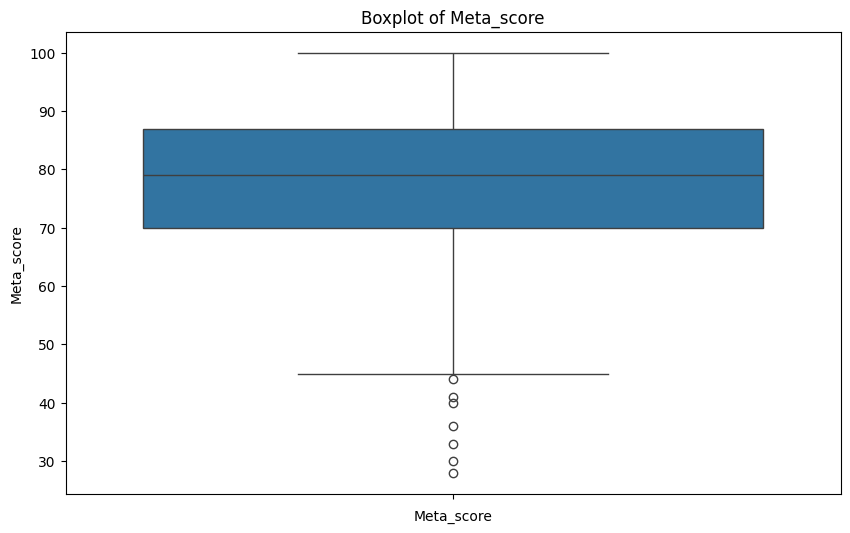

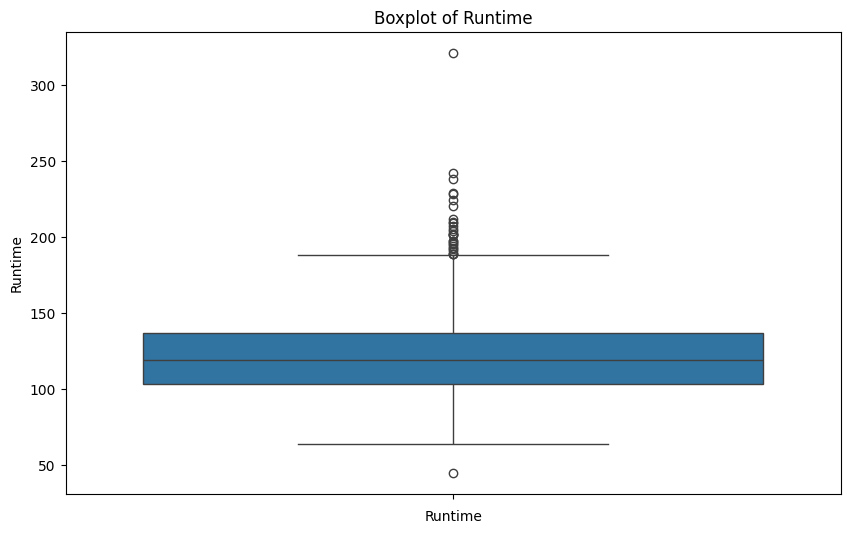

Data validation passed.
Data stored in SQLite table 'processed_data'


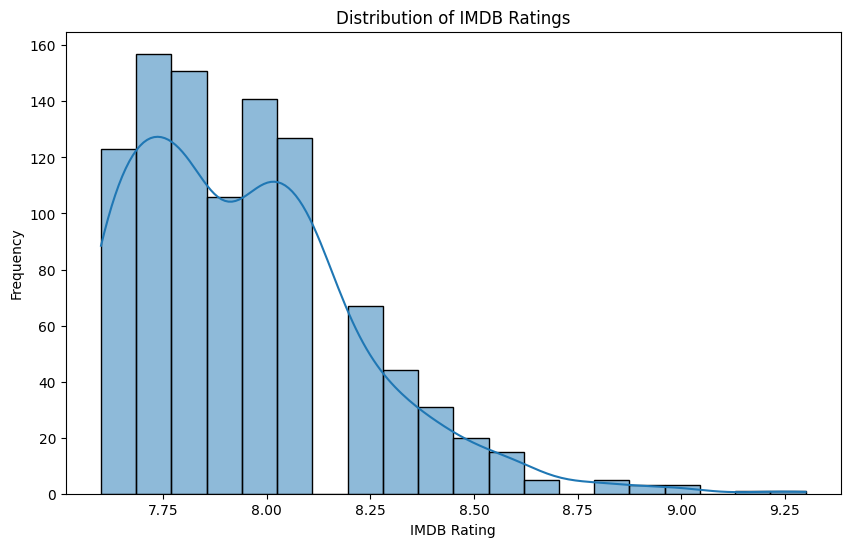

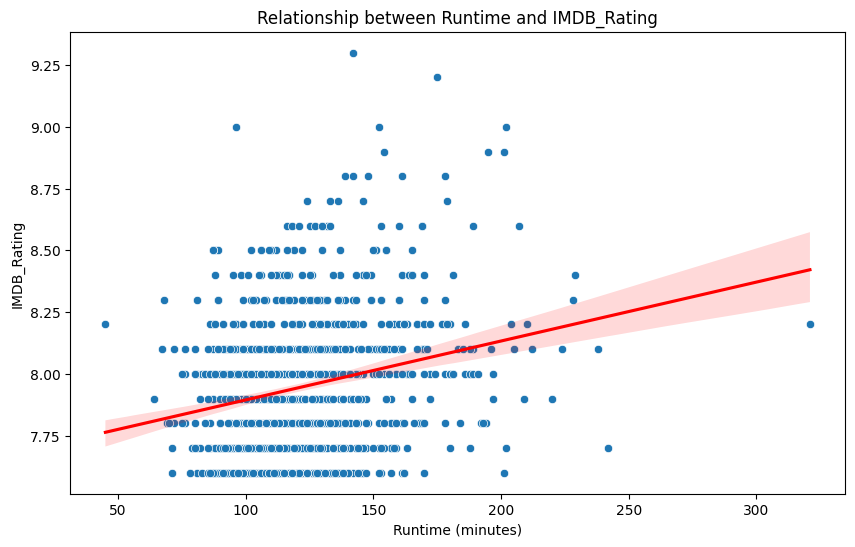

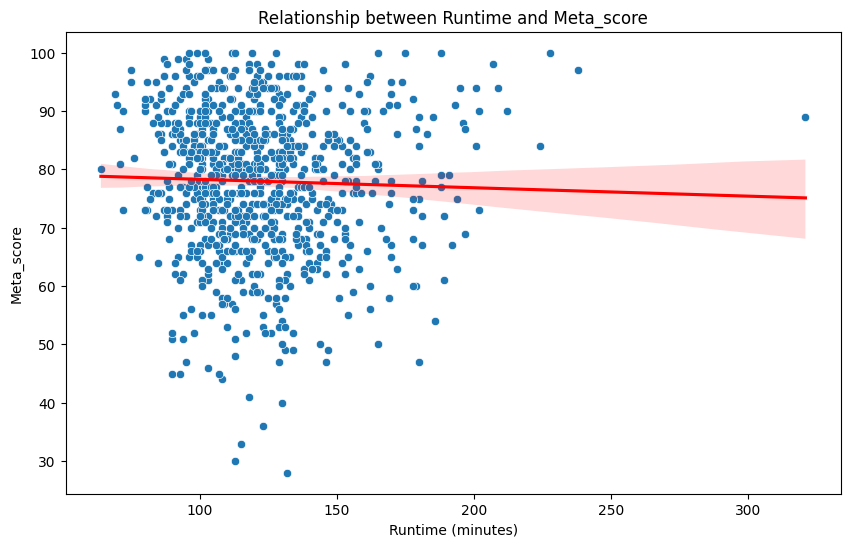

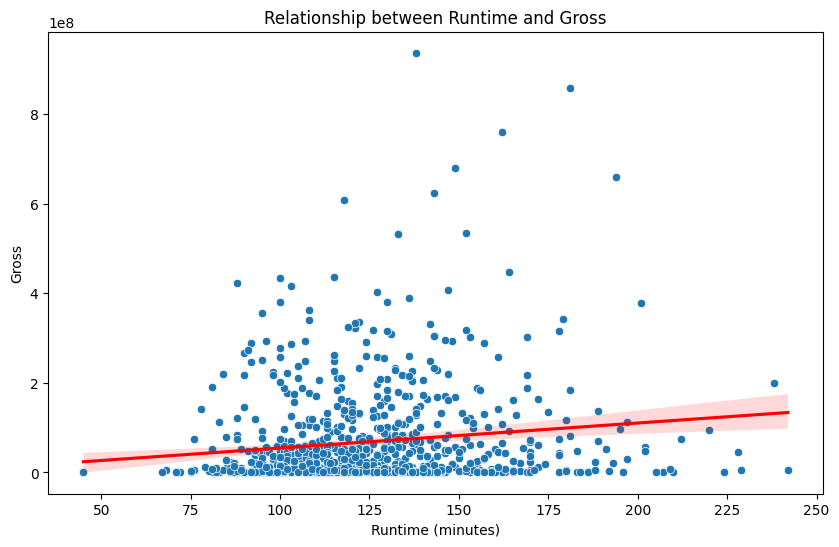


=== Exploratory Data Analysis ===

Numerical Summary:
       Released_Year      Runtime  IMDB_Rating  Meta_score   No_of_Votes  \
count     999.000000  1000.000000  1000.000000  843.000000  1.000000e+03   
mean     1991.217217   122.891000     7.949300   77.971530  2.736929e+05   
std        23.297025    28.093671     0.275491   12.376099  3.273727e+05   
min      1920.000000    45.000000     7.600000   28.000000  2.508800e+04   
25%      1976.000000   103.000000     7.700000   70.000000  5.552625e+04   
50%      1999.000000   119.000000     7.900000   79.000000  1.385485e+05   
75%      2009.000000   137.000000     8.100000   87.000000  3.741612e+05   
max      2020.000000   321.000000     9.300000  100.000000  2.343110e+06   

              Gross  
count  8.310000e+02  
mean   6.803475e+07  
std    1.097500e+08  
min    1.305000e+03  
25%    3.253559e+06  
50%    2.353089e+07  
75%    8.075089e+07  
max    9.366622e+08  

Correlation Matrix:
               Released_Year   Runtime  I

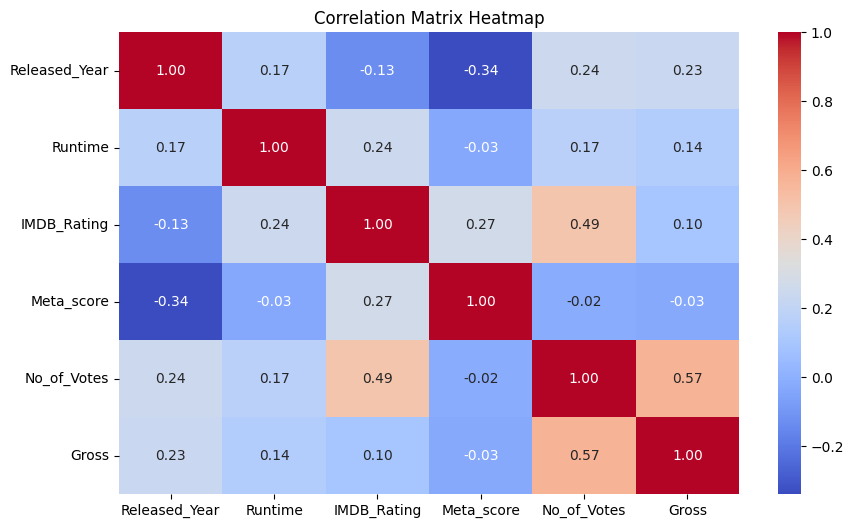

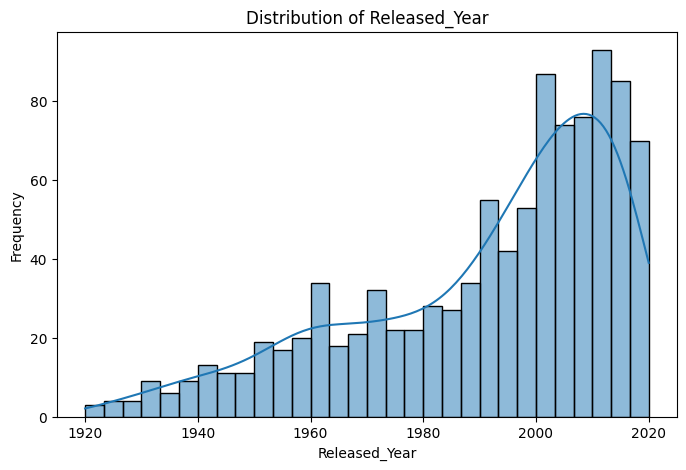

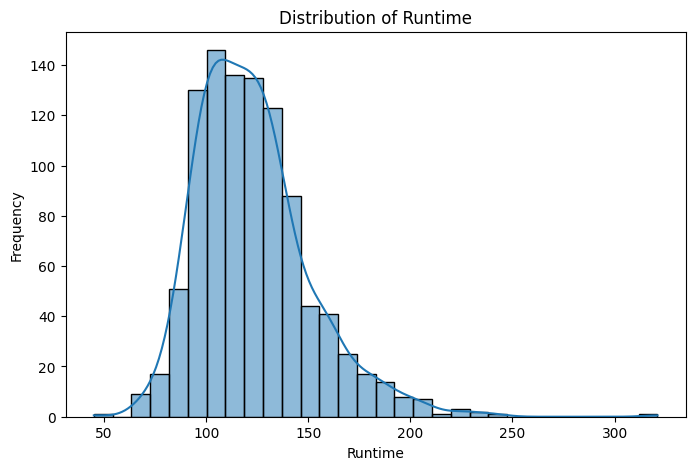

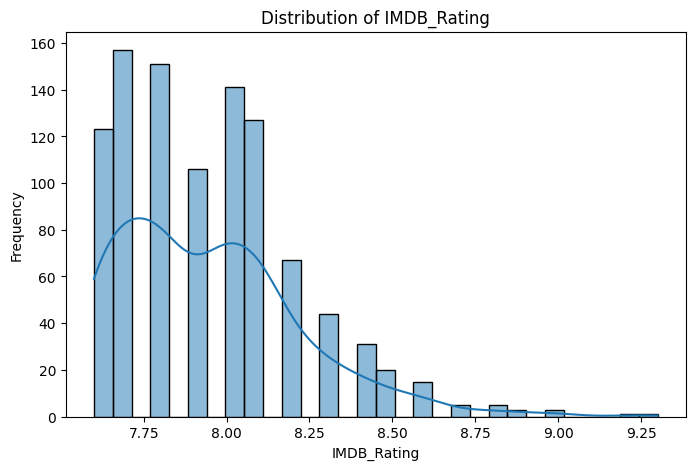

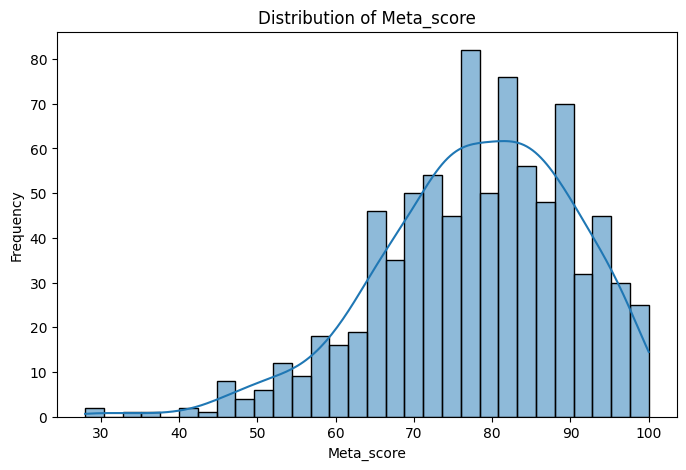

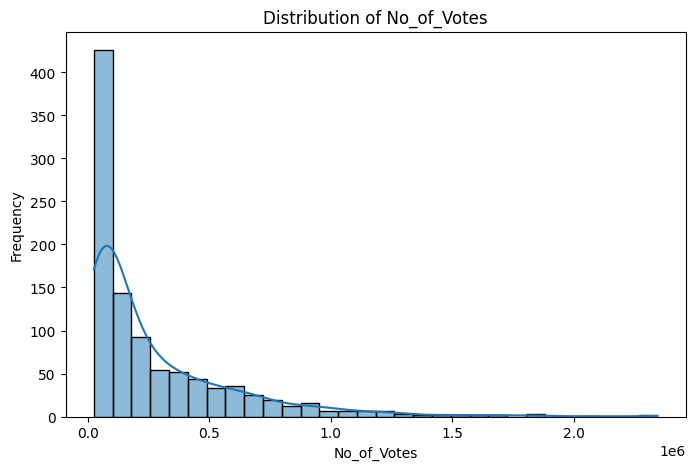

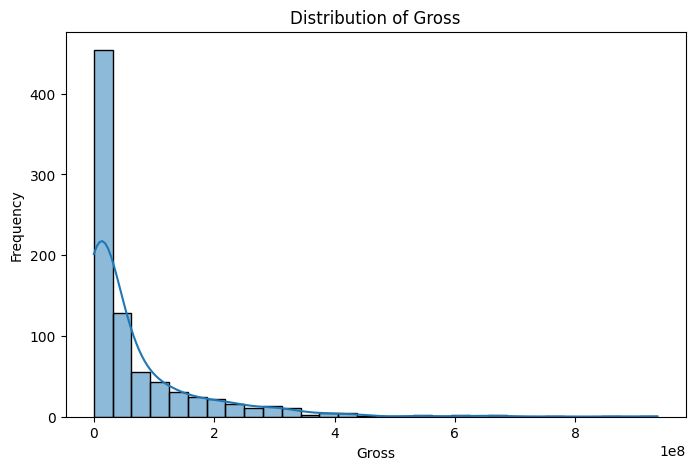


=== Advanced Visualizations ===


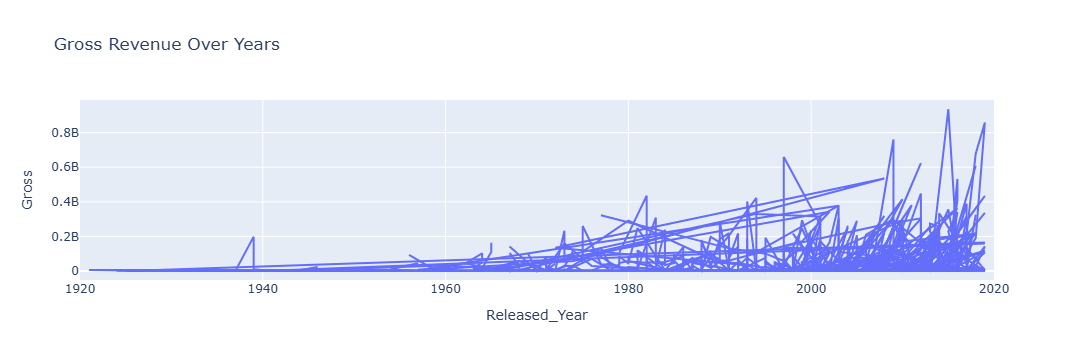


=== Statistical Analysis ===

Simple Linear Regression: IMDB Rating vs Runtime
                            OLS Regression Results                            
Dep. Variable:            IMDB_Rating   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     62.68
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           6.44e-15
Time:                        19:15:33   Log-Likelihood:                -98.782
No. Observations:                1000   AIC:                             201.6
Df Residuals:                     998   BIC:                             211.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

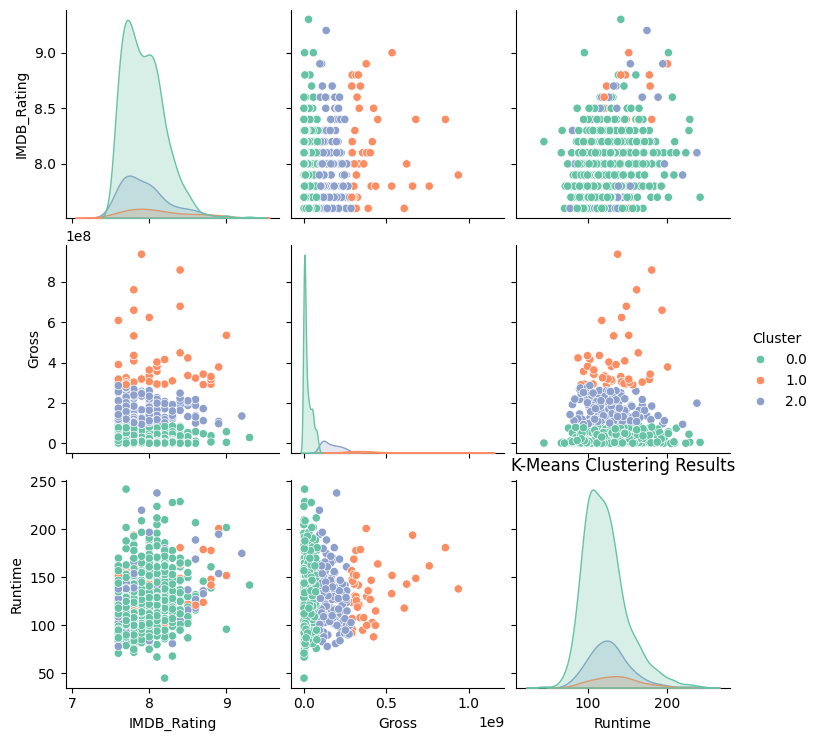


=== Insights Summary ===
Correlation between Gross Revenue and IMDB Rating: 0.10 (p-value: 0.006)


In [41]:
import os
import pandas as pd
import json
import sqlite3
import requests
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import storage

def download_kaggle_dataset(dataset_name, file_name):
    try:
        dataset_path = kagglehub.dataset_download(dataset_name)
        return os.path.join(dataset_path, file_name)
    except Exception as e:
        raise ValueError(f"Error downloading dataset: {str(e)}")

# Function to load data from various sources
def load_data(file_path_or_url, api_key=None):
    try:
        if file_path_or_url.startswith(('http://', 'https://')):
            params = {'access_key': api_key} if api_key else {}
            response = requests.get(file_path_or_url, params=params)
            response.raise_for_status()
            content_type = response.headers['Content-Type']
            if 'application/json' in content_type:
                data = pd.DataFrame(response.json()['data'])
            elif 'text/csv' in content_type:
                from io import StringIO
                data = pd.read_csv(StringIO(response.text))
            else:
                raise ValueError("Unsupported Content-Type from API!")
        elif file_path_or_url.endswith('.csv'):
            data = pd.read_csv(file_path_or_url)
        elif file_path_or_url.endswith('.json'):
            with open(file_path_or_url, 'r') as f:
                data = pd.DataFrame(json.load(f))
        else:
            raise ValueError("Unsupported file format!")
        print(f"Loaded {len(data)} records from {file_path_or_url}")
        return data
    except Exception as e:
        raise ValueError(f"Error loading data: {str(e)}")

# Data validation function
def validate_data(data):
    missing_values = data.isnull().sum().sum()
    if missing_values > 0:
        print(f"Warning: Data contains {missing_values} missing values.")
    if data.empty:
        raise ValueError("Data is empty; cannot proceed with loading.")
    print("Data validation passed.")

# Function to generate JSON-serializable summary statistics
def generate_summary_statistics(data):
    summary = {
        "Row count": len(data),
        "Column count": len(data.columns),
        "Missing values": data.isnull().sum().to_dict(),
        "Data types": data.dtypes.astype(str).to_dict(),
        "Descriptive statistics": data.describe(include='all').fillna("NaN").to_dict()
    }
    print(json.dumps(summary, indent=4))
    return summary

# Modify columns in the dataset
def modify_columns(data, drop_columns=None, add_columns=None):
    if drop_columns:
        data = data.drop(columns=drop_columns)
        print(f"Dropped columns: {drop_columns}")
    if add_columns:
        for col, default_value in add_columns.items():
            data[col] = default_value
        print(f"Added columns: {list(add_columns.keys())} with default values.")
    return data

# Apply additional transformations
def apply_transformations(data, transformations=None):
    if 'Gross' in data.columns:
        data['Gross'] = pd.to_numeric(data['Gross'].str.replace(',', ''), errors='coerce')
        print("Cleaned 'Gross' column: Converted to numeric.")

    if 'Released_Year' in data.columns:
        data['Released_Year'] = pd.to_numeric(data['Released_Year'].str.extract(r'(\d{4})')[0], errors='coerce')
        print("Extracted and cleaned 'Released_Year' column: Converted to numeric.")

    if 'Runtime' in data.columns:
        data['Runtime'] = pd.to_numeric(data['Runtime'].str.replace('min', '').str.strip(), errors='coerce')
        print("Cleaned 'Runtime' column: Removed 'min' and converted to numeric.")
        
    if transformations:
        for col, func in transformations.items():
            if col in data.columns:
                data[col] = data[col].apply(func)
                print(f"Applied transformation to column: {col}")
    
    return data

# Visualization functions
def create_visualizations(data, column_mappings):
    try:
        for col, plot_type in column_mappings.items():
            plt.figure(figsize=(10, 6))
            if plot_type == 'histogram':
                sns.histplot(data[col], kde=True, bins=30)
                plt.title(f"Distribution of {col}")
            elif plot_type == 'boxplot':
                sns.boxplot(data=data[col])
                plt.title(f"Boxplot of {col}")
            elif plot_type == 'lineplot' and 'Released_Year' in data.columns:
                plt.plot(data['Released_Year'], data[col])
                plt.title(f"{col} Over Time")
            plt.xlabel(col)
            plt.show()

    except Exception as e:
        print(f"Error in visualization: {str(e)}")

# Store data into SQLite
def store_in_sqlite(data, table_name):
    try:
        validate_data(data)
        conn = sqlite3.connect('etl_data.db')
        data.to_sql(table_name, conn, if_exists='replace', index=False)
        print(f"Data stored in SQLite table '{table_name}'")
        conn.close()
    except Exception as e:
        print(f"Error storing data in SQLite: {str(e)}")

def preprocess_genres(data):
    if 'Genre' in data.columns:
        data['Genre'] = data['Genre'].str.split(', ')
        data = data.explode('Genre').reset_index(drop=True)
        print("Expanded Genre column into unique genres.")
    return data

def graph_IMDB_rating(data):
    if 'IMDB_Rating' in data.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(data['IMDB_Rating'], bins=20, kde=True)
        plt.title('Distribution of IMDB Ratings')
        plt.xlabel('IMDB Rating')
        plt.ylabel('Frequency')
        plt.show()
        
def graph_genre(data):        
    if 'Genre' in data.columns:
        genre_counts = data['Genre'].value_counts().head(10)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=genre_counts.index, y=genre_counts.values)
        plt.title('Top 10 Genres by Movie Count')
        plt.xlabel('Genre')
        plt.ylabel('Number of Movies')
        plt.xticks(rotation=45)
        plt.show()

# Additions for Data Analysis and Statistical Analysis
import plotly.express as px
import statsmodels.api as sm
from sklearn.cluster import KMeans
from scipy.stats import pearsonr

# Function for exploratory data analysis
def exploratory_data_analysis(data):
    print("\n=== Exploratory Data Analysis ===")
    
    # Summary statistics for numerical columns
    print("\nNumerical Summary:")
    print(data.describe())
    
    # Correlation matrix
    print("\nCorrelation Matrix:")
    corr_matrix = data.corr()
    print(corr_matrix)
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title("Correlation Matrix Heatmap")
    plt.show()
    
    # Distribution plots for key numerical variables
    numerical_columns = data.select_dtypes(include=['number']).columns
    for col in numerical_columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(data[col], kde=True, bins=30)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()

def advanced_visualizations(data):
    print("\n=== Advanced Visualizations ===")
    
    # Interactive line chart for trends
    if 'Released_Year' in data.columns and 'Gross' in data.columns:
        fig = px.line(data, x='Released_Year', y='Gross', title='Gross Revenue Over Years')
        fig.show()
    
    # Geographical map example
    if 'Country' in data.columns and 'IMDB_Rating' in data.columns:
        country_avg_rating = data.groupby('Country')['IMDB_Rating'].mean().reset_index()
        fig = px.choropleth(
            country_avg_rating,
            locations='Country',
            locationmode='country names',
            color='IMDB_Rating',
            title="Average IMDB Rating by Country"
        )
        fig.show()


def statistical_analysis(data):
    print("\n=== Statistical Analysis ===")
    
    # Regression example
    if 'IMDB_Rating' in data.columns and 'Runtime' in data.columns:
        print("\nSimple Linear Regression: IMDB Rating vs Runtime")
        X = sm.add_constant(data['Runtime'])
        y = data['IMDB_Rating']
        model = sm.OLS(y, X, missing='drop').fit()
        print(model.summary())
    
    # Clustering example
    if {'IMDB_Rating', 'Gross', 'Runtime'}.issubset(data.columns):
        print("\nK-Means Clustering:")
        # Select data for clustering and drop rows with missing values
        kmeans_data = data[['IMDB_Rating', 'Gross', 'Runtime']].dropna()
        
        # Apply K-Means clustering
        kmeans = KMeans(n_clusters=3, random_state=0).fit(kmeans_data)
        cluster_labels = kmeans.labels_
        
        # Create a new DataFrame with the same index as the cleaned data
        kmeans_data_with_clusters = kmeans_data.copy()
        kmeans_data_with_clusters['Cluster'] = cluster_labels
        
        # Merge the cluster information back to the original dataset
        data = data.merge(kmeans_data_with_clusters[['Cluster']], how='left', left_index=True, right_index=True)
        
        # Display cluster centers and pairplot
        print(f"Cluster Centers: \n{kmeans.cluster_centers_}")
        sns.pairplot(data.dropna(subset=['Cluster']), vars=['IMDB_Rating', 'Gross', 'Runtime'], hue='Cluster', palette='Set2')
        plt.title("K-Means Clustering Results")
        plt.show()

def summarize_insights(data):
    print("\n=== Insights Summary ===")
    
    # Check if the required columns are present in the data
    if {'Gross', 'IMDB_Rating'}.issubset(data.columns):
        # Drop rows with missing values in the relevant columns
        valid_data = data[['Gross', 'IMDB_Rating']].dropna()
        
        if len(valid_data) > 1:  # Ensure there is enough data for correlation
            correlation, p_value = pearsonr(valid_data['Gross'], valid_data['IMDB_Rating'])
            print(f"Correlation between Gross Revenue and IMDB Rating: {correlation:.2f} (p-value: {p_value:.3f})")
        else:
            print("Not enough data to calculate correlation between Gross Revenue and IMDB Rating.")
    else:
        print("Required columns ('Gross', 'IMDB_Rating') are not present in the data.")


def upload_to_bucket(bucket_name, source_file_name, destination_blob_name):


# Main ETL process
def etl_process(
    dataset_name, file_name, output_format='csv', store_sql=False, drop_columns=None, 
    add_columns=None, transformations=None, visualization_mapping=None, api_key=None
):
    try:
        file_path = download_kaggle_dataset(dataset_name, file_name)
        data = load_data(file_path, api_key)
        
        print("Initial Data Summary:")
        initial_summary = generate_summary_statistics(data)

        # Modify and transform data
        data = modify_columns(data, drop_columns, add_columns)
        data = apply_transformations(data, transformations)

        print("Transformed Data Summary:")
        transformed_summary = generate_summary_statistics(data)

        # Generate visualizations
        if visualization_mapping:
            create_visualizations(data, visualization_mapping)

        # Save processed data
        if output_format == 'csv':
            data.to_csv("processed_data.csv", index=False)
        elif output_format == 'json':
            data.to_json("processed_data.json", orient='records', lines=True)

        if store_sql:
            store_in_sqlite(data, table_name="processed_data")

        # Genre and IMDB analysis
        graph_IMDB_rating(data)
        data = preprocess_genres(data)
        graph_genre(data)
        graph_runtime_relationships(data)
        graph_genre_relationships(data)
        graph_combined_effects(data, 'IMDB_Rating')

        # EDA and Statistical Analysis
        exploratory_data_analysis(data)
        advanced_visualizations(data)
        statistical_analysis(data)
        summarize_insights(data)

    except Exception as e:
        print(f"ETL process error: {str(e)}")


etl_process(
    dataset_name="harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows",
    file_name="imdb_top_1000.csv",
    output_format='json',
    store_sql=True,
    drop_columns=['Overview', 'Certificate', 'Poster_Link', 'Star1', 'Star2', 'Star3', 'Star4', 'Series_Title', 'Genre', 'Director'],
    transformations={'Gross': lambda x: float(x.replace(',', '')) if isinstance(x, str) else x},
    visualization_mapping={'IMDB_Rating': 'histogram', 'Meta_score': 'boxplot', 'Runtime': 'boxplot'}
)

def graph_runtime_relationships(data):
    numerical_columns = ['IMDB_Rating', 'Meta_score', 'Gross']
    
    for col in numerical_columns:
        if col in data.columns and 'Runtime' in data.columns:
            plt.figure(figsize=(10, 6))
            sns.scatterplot(data=data, x='Runtime', y=col)
            sns.regplot(data=data, x='Runtime', y=col, scatter=False, color='red')
            plt.title(f"Relationship between Runtime and {col}")
            plt.xlabel("Runtime (minutes)")
            plt.ylabel(col)
            plt.show()

def graph_genre_relationships(data):
    if 'Genre' in data.columns:
        categorical_columns = ['IMDB_Rating', 'Meta_score', 'Gross']
        
        for col in categorical_columns:
            if col in data.columns:
                plt.figure(figsize=(12, 8))
                sns.boxplot(data=data, x='Genre', y=col)
                plt.xticks(rotation=45)
                plt.title(f"Impact of Genre on {col}")
                plt.xlabel("Genre")
                plt.ylabel(col)
                plt.show()


def graph_combined_effects(data, target_column):
    if 'Runtime' in data.columns and 'Genre' in data.columns and target_column in data.columns:
        data['Runtime_Group'] = pd.qcut(data['Runtime'], q=4, labels=['Short', 'Medium', 'Long', 'Very Long'])
        pivot = data.pivot_table(index='Genre', columns='Runtime_Group', values=target_column, aggfunc='mean')
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot, annot=True, fmt='.1f', cmap='coolwarm')
        plt.title(f"Combined Effect of Genre and Runtime on {target_column}")
        plt.xlabel("Runtime Group")
        plt.ylabel("Genre")
        plt.show()







In [ ]:
import os
import pandas as pd
import json
import sqlite3
import requests
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns

def download_kaggle_dataset(dataset_name, file_name):
    try:
        dataset_path = kagglehub.dataset_download(dataset_name)
        return os.path.join(dataset_path, file_name)
    except Exception as e:
        raise ValueError(f"Error downloading dataset: {str(e)}")

# Function to load data from various sources
def load_data(file_path_or_url, api_key=None):
    try:
        if file_path_or_url.startswith(('http://', 'https://')):
            params = {'access_key': api_key} if api_key else {}
            response = requests.get(file_path_or_url, params=params)
            response.raise_for_status()
            content_type = response.headers['Content-Type']
            if 'application/json' in content_type:
                data = pd.DataFrame(response.json()['data'])
            elif 'text/csv' in content_type:
                from io import StringIO
                data = pd.read_csv(StringIO(response.text))
            else:
                raise ValueError("Unsupported Content-Type from API!")
        elif file_path_or_url.endswith('.csv'):
            data = pd.read_csv(file_path_or_url)
        elif file_path_or_url.endswith('.json'):
            with open(file_path_or_url, 'r') as f:
                data = pd.DataFrame(json.load(f))
        else:
            raise ValueError("Unsupported file format!")
        print(f"Loaded {len(data)} records from {file_path_or_url}")
        return data
    except Exception as e:
        raise ValueError(f"Error loading data: {str(e)}")

# Data validation function
def validate_data(data):
    missing_values = data.isnull().sum().sum()
    if missing_values > 0:
        print(f"Warning: Data contains {missing_values} missing values.")
    if data.empty:
        raise ValueError("Data is empty; cannot proceed with loading.")
    print("Data validation passed.")

# Function to generate JSON-serializable summary statistics
def generate_summary_statistics(data):
    summary = {
        "Row count": len(data),
        "Column count": len(data.columns),
        "Missing values": data.isnull().sum().to_dict(),
        "Data types": data.dtypes.astype(str).to_dict(),
        "Descriptive statistics": data.describe(include='all').fillna("NaN").to_dict()
    }
    print(json.dumps(summary, indent=4))
    return summary

# Modify columns in the dataset
def modify_columns(data, drop_columns=None, add_columns=None):
    if drop_columns:
        data = data.drop(columns=drop_columns)
        print(f"Dropped columns: {drop_columns}")
    if add_columns:
        for col, default_value in add_columns.items():
            data[col] = default_value
        print(f"Added columns: {list(add_columns.keys())} with default values.")
    return data

# Apply additional transformations
def apply_transformations(data, transformations=None):
    if 'Gross' in data.columns:
        data['Gross'] = pd.to_numeric(data['Gross'].str.replace(',', ''), errors='coerce')
        print("Cleaned 'Gross' column: Converted to numeric.")

    if 'Released_Year' in data.columns:
        data['Released_Year'] = pd.to_numeric(data['Released_Year'].str.extract(r'(\d{4})')[0], errors='coerce')
        print("Extracted and cleaned 'Released_Year' column: Converted to numeric.")

    if 'Runtime' in data.columns:
        data['Runtime'] = pd.to_numeric(data['Runtime'].str.replace('min', '').str.strip(), errors='coerce')
        print("Cleaned 'Runtime' column: Removed 'min' and converted to numeric.")
        
    if transformations:
        for col, func in transformations.items():
            if col in data.columns:
                data[col] = data[col].apply(func)
                print(f"Applied transformation to column: {col}")
    
    return data

# Visualization functions
def create_visualizations(data, column_mappings):
    try:
        for col, plot_type in column_mappings.items():
            plt.figure(figsize=(10, 6))
            if plot_type == 'histogram':
                sns.histplot(data[col], kde=True, bins=30)
                plt.title(f"Distribution of {col}")
            elif plot_type == 'boxplot':
                sns.boxplot(data=data[col])
                plt.title(f"Boxplot of {col}")
            elif plot_type == 'lineplot' and 'Released_Year' in data.columns:
                plt.plot(data['Released_Year'], data[col])
                plt.title(f"{col} Over Time")
            plt.xlabel(col)
            plt.show()

    except Exception as e:
        print(f"Error in visualization: {str(e)}")

# Store data into SQLite
def store_in_sqlite(data, table_name):
    try:
        validate_data(data)
        conn = sqlite3.connect('etl_data.db')
        data.to_sql(table_name, conn, if_exists='replace', index=False)
        print(f"Data stored in SQLite table '{table_name}'")
        conn.close()
    except Exception as e:
        print(f"Error storing data in SQLite: {str(e)}")

def preprocess_genres(data):
    if 'Genre' in data.columns:
        data['Genre'] = data['Genre'].str.split(', ')
        data = data.explode('Genre').reset_index(drop=True)
        print("Expanded Genre column into unique genres.")
    return data

def graph_IMDB_rating(data):
    if 'IMDB_Rating' in data.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(data['IMDB_Rating'], bins=20, kde=True)
        plt.title('Distribution of IMDB Ratings')
        plt.xlabel('IMDB Rating')
        plt.ylabel('Frequency')
        plt.show()
        
def graph_genre(data):        
    if 'Genre' in data.columns:
        genre_counts = data['Genre'].value_counts().head(10)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=genre_counts.index, y=genre_counts.values)
        plt.title('Top 10 Genres by Movie Count')
        plt.xlabel('Genre')
        plt.ylabel('Number of Movies')
        plt.xticks(rotation=45)
        plt.show()

# Additions for Data Analysis and Statistical Analysis
import plotly.express as px
import statsmodels.api as sm
from sklearn.cluster import KMeans
from scipy.stats import pearsonr

# Function for exploratory data analysis
def exploratory_data_analysis(data):
    print("\n=== Exploratory Data Analysis ===")
    
    # Summary statistics for numerical columns
    print("\nNumerical Summary:")
    print(data.describe())
    
    # Correlation matrix
    print("\nCorrelation Matrix:")
    corr_matrix = data.corr()
    print(corr_matrix)
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title("Correlation Matrix Heatmap")
    plt.show()
    
    # Distribution plots for key numerical variables
    numerical_columns = data.select_dtypes(include=['number']).columns
    for col in numerical_columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(data[col], kde=True, bins=30)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()

def advanced_visualizations(data):
    print("\n=== Advanced Visualizations ===")
    
    # Interactive line chart for trends
    if 'Released_Year' in data.columns and 'Gross' in data.columns:
        fig = px.line(data, x='Released_Year', y='Gross', title='Gross Revenue Over Years')
        fig.show()
    
    # Geographical map example
    if 'Country' in data.columns and 'IMDB_Rating' in data.columns:
        country_avg_rating = data.groupby('Country')['IMDB_Rating'].mean().reset_index()
        fig = px.choropleth(
            country_avg_rating,
            locations='Country',
            locationmode='country names',
            color='IMDB_Rating',
            title="Average IMDB Rating by Country"
        )
        fig.show()


def statistical_analysis(data):
    print("\n=== Statistical Analysis ===")
    
    # Regression example
    if 'IMDB_Rating' in data.columns and 'Runtime' in data.columns:
        print("\nSimple Linear Regression: IMDB Rating vs Runtime")
        X = sm.add_constant(data['Runtime'])
        y = data['IMDB_Rating']
        model = sm.OLS(y, X, missing='drop').fit()
        print(model.summary())
    
    # Clustering example
    if {'IMDB_Rating', 'Gross', 'Runtime'}.issubset(data.columns):
        print("\nK-Means Clustering:")
        # Select data for clustering and drop rows with missing values
        kmeans_data = data[['IMDB_Rating', 'Gross', 'Runtime']].dropna()
        
        # Apply K-Means clustering
        kmeans = KMeans(n_clusters=3, random_state=0).fit(kmeans_data)
        cluster_labels = kmeans.labels_
        
        # Create a new DataFrame with the same index as the cleaned data
        kmeans_data_with_clusters = kmeans_data.copy()
        kmeans_data_with_clusters['Cluster'] = cluster_labels
        
        # Merge the cluster information back to the original dataset
        data = data.merge(kmeans_data_with_clusters[['Cluster']], how='left', left_index=True, right_index=True)
        
        # Display cluster centers and pairplot
        print(f"Cluster Centers: \n{kmeans.cluster_centers_}")
        sns.pairplot(data.dropna(subset=['Cluster']), vars=['IMDB_Rating', 'Gross', 'Runtime'], hue='Cluster', palette='Set2')
        plt.title("K-Means Clustering Results")
        plt.show()

def summarize_insights(data):
    print("\n=== Insights Summary ===")
    
    # Check if the required columns are present in the data
    if {'Gross', 'IMDB_Rating'}.issubset(data.columns):
        # Drop rows with missing values in the relevant columns
        valid_data = data[['Gross', 'IMDB_Rating']].dropna()
        
        if len(valid_data) > 1:  # Ensure there is enough data for correlation
            correlation, p_value = pearsonr(valid_data['Gross'], valid_data['IMDB_Rating'])
            print(f"Correlation between Gross Revenue and IMDB Rating: {correlation:.2f} (p-value: {p_value:.3f})")
        else:
            print("Not enough data to calculate correlation between Gross Revenue and IMDB Rating.")
    else:
        print("Required columns ('Gross', 'IMDB_Rating') are not present in the data.")


# Main ETL process
def etl_process(
    dataset_name, file_name, output_format='csv', store_sql=False, drop_columns=None, 
    add_columns=None, transformations=None, visualization_mapping=None, api_key=None
):
    try:
        file_path = download_kaggle_dataset(dataset_name, file_name)
        data = load_data(file_path, api_key)
        
        print("Initial Data Summary:")
        initial_summary = generate_summary_statistics(data)

        # Modify and transform data
        data = modify_columns(data, drop_columns, add_columns)
        data = apply_transformations(data, transformations)

        print("Transformed Data Summary:")
        transformed_summary = generate_summary_statistics(data)

        # Generate visualizations
        if visualization_mapping:
            create_visualizations(data, visualization_mapping)

        # Save processed data
        if output_format == 'csv':
            data.to_csv("processed_data.csv", index=False)
        elif output_format == 'json':
            data.to_json("processed_data.json", orient='records', lines=True)

        if store_sql:
            store_in_sqlite(data, table_name="processed_data")

        # Genre and IMDB analysis
        graph_IMDB_rating(data)
        data = preprocess_genres(data)
        graph_genre(data)
        graph_runtime_relationships(data)
        graph_genre_relationships(data)
        graph_combined_effects(data, 'IMDB_Rating')

        # EDA and Statistical Analysis
        exploratory_data_analysis(data)
        advanced_visualizations(data)
        statistical_analysis(data)
        summarize_insights(data)

    except Exception as e:
        print(f"ETL process error: {str(e)}")


etl_process(
    dataset_name="harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows",
    file_name="imdb_top_1000.csv",
    output_format='json',
    store_sql=True,
    drop_columns=['Overview', 'Certificate', 'Poster_Link', 'Star1', 'Star2', 'Star3', 'Star4', 'Series_Title', 'Genre', 'Director'],
    transformations={'Gross': lambda x: float(x.replace(',', '')) if isinstance(x, str) else x},
    visualization_mapping={'IMDB_Rating': 'histogram', 'Meta_score': 'boxplot', 'Runtime': 'boxplot'}
)

def graph_runtime_relationships(data):
    numerical_columns = ['IMDB_Rating', 'Meta_score', 'Gross']
    
    for col in numerical_columns:
        if col in data.columns and 'Runtime' in data.columns:
            plt.figure(figsize=(10, 6))
            sns.scatterplot(data=data, x='Runtime', y=col)
            sns.regplot(data=data, x='Runtime', y=col, scatter=False, color='red')
            plt.title(f"Relationship between Runtime and {col}")
            plt.xlabel("Runtime (minutes)")
            plt.ylabel(col)
            plt.show()

def graph_genre_relationships(data):
    if 'Genre' in data.columns:
        categorical_columns = ['IMDB_Rating', 'Meta_score', 'Gross']
        
        for col in categorical_columns:
            if col in data.columns:
                plt.figure(figsize=(12, 8))
                sns.boxplot(data=data, x='Genre', y=col)
                plt.xticks(rotation=45)
                plt.title(f"Impact of Genre on {col}")
                plt.xlabel("Genre")
                plt.ylabel(col)
                plt.show()


def graph_combined_effects(data, target_column):
    if 'Runtime' in data.columns and 'Genre' in data.columns and target_column in data.columns:
        data['Runtime_Group'] = pd.qcut(data['Runtime'], q=4, labels=['Short', 'Medium', 'Long', 'Very Long'])
        pivot = data.pivot_table(index='Genre', columns='Runtime_Group', values=target_column, aggfunc='mean')
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot, annot=True, fmt='.1f', cmap='coolwarm')
        plt.title(f"Combined Effect of Genre and Runtime on {target_column}")
        plt.xlabel("Runtime Group")
        plt.ylabel("Genre")
        plt.show()





